# Why stock market volatility benefits the wealthy

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import json
import math
import matplotlib.pyplot as plt
import init_objects
from functions.helpers import organise_data, hypothetical_series, get_specific_bootstraps_moments, confidence_interval
from functions.inequality import gini
from model import *
import statsmodels.api as sm
from matplotlib import style
from functions.evolutionaryalgo import *
import scipy.stats as stats
from SALib.sample import latin
import statsmodels.api as sm
import scipy.stats

In [2]:
style.use('seaborn-ticks')

In [3]:
3788 / float(10)

378.8

In [4]:
params = {"trader_sample_size": 20, # selected for comp efficiency
          "n_traders": 100, # selected for comp efficiency
          "init_stocks": int(3788 / float(10)), # Campbell et al. 2019 total stocks / n-agents 
          "ticks": 1000, # lenght of Campbell et al. 2019 data
          "fundamental_value": 1101.111,#818, # average of Campbell et al. 2019 market cap
          "std_fundamental": 0.05, # standard deviation Campell et al. prices, assuming efficient markets TODO
          "base_risk_aversion": 0.7, # estimate from Kim & Lee (2012)
          'spread_max': 0.004087, # estimate from Riordan & Storkenmaier (2012)
          "horizon": int(100 * 0.35), # estimate based on average churn ratio found by Cella, Ellul and Giannetti (2013)
          "std_noise": 0.05, 
          "w_random": 1.0, 
          # parameter only used for experiment
          "mean_reversion": 0.0,
          # fixed / not modelled parameters
          "fundamentalist_horizon_multiplier": 1.0,
          "strat_share_chartists": 0.0,
          "mutation_intensity": 0.0,
          "average_learning_ability": 0.0,
          "trades_per_tick": 1
         }

## Estimate params to replicate inequality increase?

What are the moments to replicate?

Params to estimate is stdev noise? 

## Run model

In [5]:
NRUNS = 10

In [6]:
trdrs = []
orbs = []
for seed in range(NRUNS):
    traders, orderbook = init_objects.init_objects_distr(params, seed)
    traders, orderbook = volatility_inequality_model2(traders, orderbook, params, seed)
    trdrs.append(traders)
    orbs.append(orderbook)

Start of simulation  0
Start of simulation  1
Start of simulation  2
Start of simulation  3
Start of simulation  4
Start of simulation  5
Start of simulation  6
Start of simulation  7
Start of simulation  8
Start of simulation  9


### Calculate agent wealth & log returns 

In [7]:
portfolios = {}
long_list_portfolios = {'wealth': [], 'log_wealth': [], 'returns': [], 'log_returns':[]}

for seed in range(NRUNS):
    for p_idx, portf in enumerate(trdrs[seed]):
        value_over_time = []
        log_value_over_time = []
        returns_over_time = []
        log_returns_over_time = []
        
        for t in range(params["ticks"] - 1):
            v0 = portf.var.wealth[t]
            value_over_time.append(v0)
            log_value_over_time.append(np.log(v0))
            
            v1 = portf.var.wealth[t+1]
            returns_over_time.append(((v1 - v0) / v0))
            log_returns_over_time.append(np.log(v1/v0))

        portfolios['value_{}_seed_{}'.format(p_idx, seed)] = value_over_time
        portfolios['log_value_{}_seed_{}'.format(p_idx, seed)] = log_value_over_time
        portfolios['return+1_{}_seed_{}'.format(p_idx, seed)] = returns_over_time
        portfolios['log_return+1_{}_seed_{}'.format(p_idx, seed)] = log_returns_over_time
        
        long_list_portfolios['wealth'] += value_over_time
        long_list_portfolios['log_wealth'] += log_value_over_time
        long_list_portfolios['returns'] += returns_over_time
        long_list_portfolios['log_returns'] += log_returns_over_time

## 1 Do simple returns correlate with wealth?

In [8]:
wealth_returns = pd.DataFrame(long_list_portfolios)
wealth_returns.head(2)

,wealth,log_wealth,returns,log_returns
0,625732.711325,13.346679,0.000000,0.000000
1,625732.711325,13.346679,-0.000783,-0.000783


**Scatter plot**

Text(0.5, 1.0, 'Wealth and absolute returns')

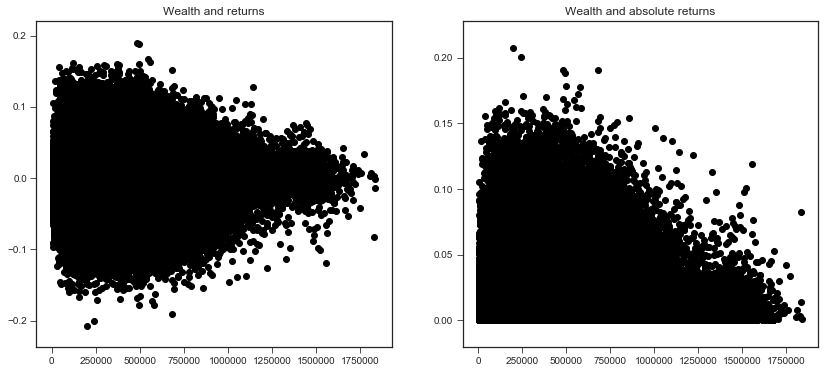

In [9]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(14,6))

ax1.scatter(wealth_returns['wealth'], wealth_returns['returns'], color='k')
ax1.set_title('Wealth and returns')

ax2.scatter(wealth_returns['wealth'], wealth_returns['returns'].abs(), color='k')
ax2.set_title('Wealth and absolute returns')

**Pearson correlation**

In [10]:
np.corrcoef(wealth_returns['wealth'], wealth_returns['returns'])

array([[ 1.        , -0.00822742],
       [-0.00822742,  1.        ]])

In [11]:
np.corrcoef(wealth_returns['wealth'], wealth_returns['returns'].abs())

array([[1.        , 0.00850137],
       [0.00850137, 1.        ]])

**Spearman rank correlation**

In [12]:
scipy.stats.spearmanr(wealth_returns['wealth'], wealth_returns['returns'])

SpearmanrResult(correlation=-0.0009665686092972234, pvalue=0.3340020395134634)

In [13]:
scipy.stats.spearmanr(wealth_returns['wealth'], wealth_returns['returns'].abs())

SpearmanrResult(correlation=0.028688362773838606, pvalue=6.799836388827027e-181)

## 2 Do log returns correlate with log wealth?

Text(0.5, 1.0, 'Log wealth and absolute returns')

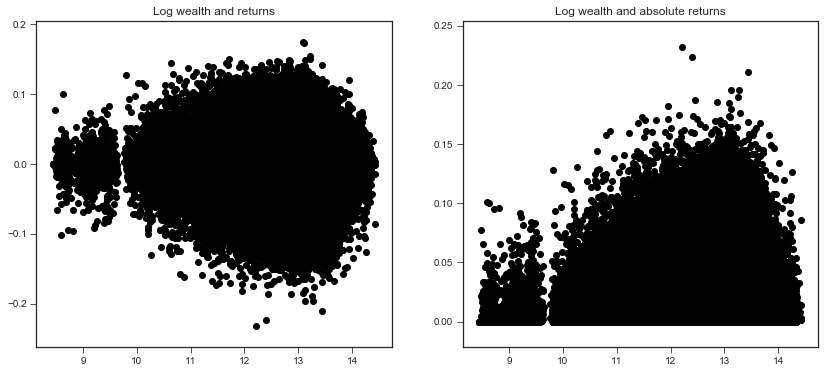

In [14]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(14,6))

ax1.scatter(wealth_returns['log_wealth'], wealth_returns['log_returns'], color='k')
ax1.set_title('Log wealth and returns')

ax2.scatter(wealth_returns['log_wealth'], wealth_returns['log_returns'].abs(), color='k')
ax2.set_title('Log wealth and absolute returns')

**Pearson correlation**

Log returns

In [15]:
np.corrcoef(wealth_returns['log_wealth'], wealth_returns['log_returns'])

array([[ 1.        , -0.00612756],
       [-0.00612756,  1.        ]])

Absolute log returns

In [16]:
np.corrcoef(wealth_returns['log_wealth'], wealth_returns['log_returns'].abs())

array([[1.        , 0.00650065],
       [0.00650065, 1.        ]])

**Spearman correlation**

In [17]:
scipy.stats.spearmanr(wealth_returns['log_wealth'], wealth_returns['log_returns'].abs())

SpearmanrResult(correlation=0.02869415369319692, pvalue=5.757930804078546e-181)

Text(0.5, 1.0, 'Y = log wealth and X = absolute returns')

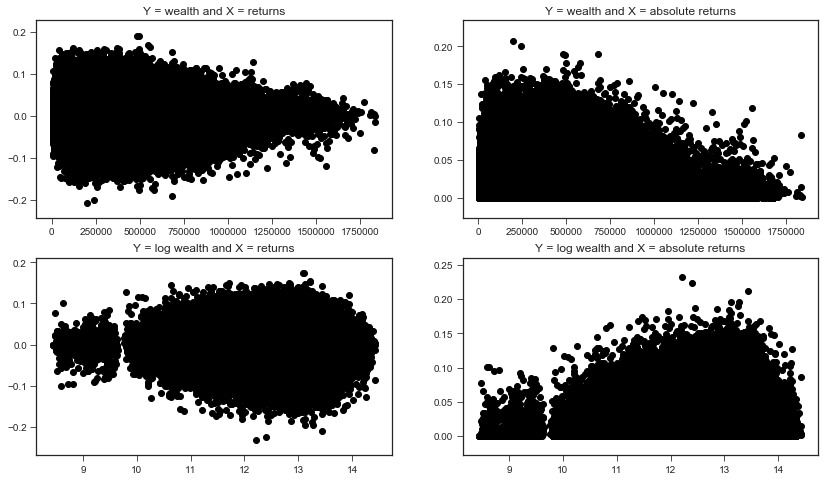

In [18]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(nrows=2, ncols=2, figsize=(14,8))

ax1.scatter(wealth_returns['wealth'], wealth_returns['returns'], color='k')
ax1.set_title('Y = wealth and X = returns')

ax2.scatter(wealth_returns['wealth'], wealth_returns['returns'].abs(), color='k')
ax2.set_title('Y = wealth and X = absolute returns')

ax3.scatter(wealth_returns['log_wealth'], wealth_returns['log_returns'], color='k')
ax3.set_title('Y = log wealth and X = returns')

ax4.scatter(wealth_returns['log_wealth'], wealth_returns['log_returns'].abs(), color='k')
ax4.set_title('Y = log wealth and X = absolute returns')

#fig.savefig('wealth_return_scatter.png')

## Model dynamics

In [19]:
mc_prices, mc_returns, mc_autocorr_returns, mc_autocorr_abs_returns, mc_volatility, mc_volume, mc_fundamentals = organise_data(orbs, burn_in_period=0)

In [20]:
lower_c_price = []
upper_c_price = []
for row in range(len(mc_prices)):
    price_range = mc_prices.iloc[row]
    lower, upper = confidence_interval(price_range, np.mean(price_range))
    lower_c_price.append(max(lower, 0.0))
    upper_c_price.append(upper)

In [21]:
wealth_starts = []
wealth_ends = []
ginis_ot = []
palmas_ot = []
returns = []
absolute_returns = []
market_returns = []

returns_ot = []
wealth_ot = []
log_returns_ot = []
log_wealth_ot = []

# determine the start and end wealth
for seed, traders in enumerate(trdrs):
    money_start = np.array([x.var.money[0] for x in traders])
    stocks_start = np.array([x.var.stocks[0] for x in traders])
    wealth_start = money_start + (stocks_start * orbs[seed].tick_close_price[0])

    money_end = np.array([x.var.money[-1] for x in traders])
    stocks_end = np.array([x.var.stocks[-1] for x in traders])
    wealth_end = money_end + (stocks_end * orbs[seed].tick_close_price[-1])
    
    # returns
    returns.append((np.array(wealth_end) - np.array(wealth_start)) / np.array(wealth_start))
    absolute_returns.append(np.array(wealth_end) - np.array(wealth_start))
    market_returns.append([(orbs[seed].tick_close_price[-1] - orbs[seed].tick_close_price[0]) / orbs[seed].tick_close_price[0] for x in range(len(wealth_start))])

    wealth_gini_over_time = []
    palma_over_time = []
    
    wealth_over_time = []
    returns_over_time = []
    log_returns_over_time = []
    log_wealth_over_time = []
    for t in range(params["ticks"]):
        money = np.array([x.var.money[t] for x in traders])
        stocks = np.array([x.var.stocks[t] for x in traders])
        wealth = money + (stocks * orbs[seed].tick_close_price[t])

        share_top_10 = sum(np.sort(wealth)[int(len(wealth) * 0.9):]) / sum(wealth)
        share_bottom_40 = sum(np.sort(wealth)[:int(len(wealth) * 0.4)]) / sum(wealth)
        palma_over_time.append(share_top_10 / share_bottom_40)

        wealth_gini_over_time.append(gini(wealth))
        
        for a in range(len(traders)):
            wealth_over_time.append(wealth[a])
            log_wealth_over_time.append(np.log(wealth[a]))

            if t > 0:
                returns_over_time.append((wealth_over_time[t] - wealth_over_time[t-1]) / wealth_over_time[-1])
                log_returns_over_time.append(np.log(wealth_over_time[t] / wealth_over_time[t-1])) # log returns = log(return + 1)

    wealth_starts.append(list(wealth_start))
    wealth_ends.append(list(wealth_end))
    ginis_ot.append(wealth_gini_over_time)
    palmas_ot.append(palma_over_time)
    
    returns_ot.append(returns_over_time)
    wealth_ot.append(wealth_over_time)
    log_returns_ot.append(log_returns_over_time)
    log_wealth_ot.append(log_wealth_over_time)

In [22]:
av_gini_ot = []
low_gini_ot = []
up_gini_ot = []

av_palma_ot = []
low_palma_ot = []
up_palma_ot = []

for t in range(params["ticks"]):
    t_gini = [g[t] for g in ginis_ot]
    av_gini_ot.append(np.mean(t_gini))
    low, up = confidence_interval(t_gini, np.mean(t_gini))
    low_gini_ot.append(low)
    up_gini_ot.append(up)

    t_palma = [p[t] for p in palmas_ot]
    av_palma_ot.append(np.mean(t_palma))
    low, up = confidence_interval(t_palma, np.mean(t_palma))
    low_palma_ot.append(low)
    up_palma_ot.append(up)

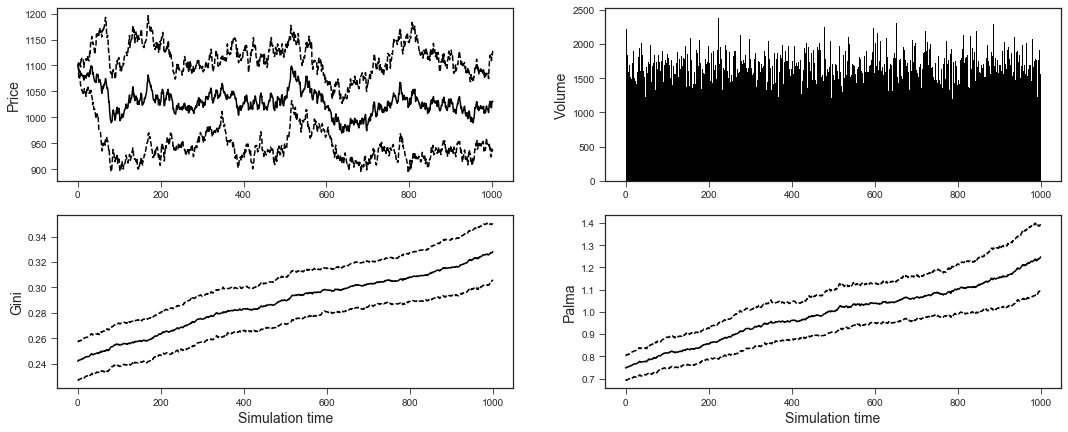

In [24]:
fig, ((ax1, ax2),(ax3, ax4)) = plt.subplots(2, 2, figsize=(18,7))

ax1.plot(mc_prices.index, mc_prices.mean(axis=1), 'k', label='Market')
ax1.plot(mc_prices.index[:], lower_c_price, 'k--')
ax1.plot(mc_prices.index[:], upper_c_price, 'k--')
ax1.set_ylabel('Price', fontsize='14')

ax2.bar(mc_volume.index, mc_volume.mean(axis=1), width=1.0, color='black')
ax2.set_ylabel('Volume', fontsize='14')

ax3.plot(range(len(av_gini_ot[:])), av_gini_ot[:], 'k')
ax3.plot(range(len(low_gini_ot[:])), low_gini_ot[:], 'k--')
ax3.plot(range(len(up_gini_ot[:])), up_gini_ot[:], 'k--')
ax3.set_ylabel('Gini', fontsize='14')

ax4.plot(range(len(av_gini_ot[:])), av_palma_ot[:], 'k')
ax4.plot(range(len(low_gini_ot[:])), low_palma_ot[:], 'k--')
ax4.plot(range(len(up_gini_ot[:])), up_palma_ot[:], 'k--')
ax4.set_ylabel('Palma', fontsize='14')


for ax in (ax3, ax4):
    ax.set_xlabel('Simulation time', fontsize='14')
    

fig.savefig('uct_baseline_dynamics.png', dpi=200, bbox_inches = 'tight', pad_inches = 0)

# Experiment

In [124]:
stdev_fun = [x / 100.0 for x in range(0, 100, 5)]
stdev_fun = stdev_fun[1:11]

In [125]:
NRUNS = 5

In [126]:
stdev_fun 

[0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5]

In [127]:
experiments = len(stdev_fun)

In [132]:
trdrs = []
orbs = []

for exp in range(experiments):
    params['std_noise'] = stdev_fun[exp]
    for seed in range(NRUNS): 
        traders, orderbook = init_objects.init_objects_distr(params, seed)
        traders, orderbook = volatility_inequality_model2(traders, orderbook, params, seed)
        trdrs.append(traders)
        orbs.append(orderbook)

Start of simulation  0
Start of simulation  1
Start of simulation  2
Start of simulation  3
Start of simulation  4
Start of simulation  0
Start of simulation  1
Start of simulation  2
Start of simulation  3
Start of simulation  4
Start of simulation  0
Start of simulation  1
Start of simulation  2
Start of simulation  3
Start of simulation  4
Start of simulation  0
Start of simulation  1
Start of simulation  2
Start of simulation  3
Start of simulation  4
Start of simulation  0
Start of simulation  1
Start of simulation  2
Start of simulation  3
Start of simulation  4
Start of simulation  0
Start of simulation  1
Start of simulation  2
Start of simulation  3
Start of simulation  4
Start of simulation  0
Start of simulation  1
Start of simulation  2
Start of simulation  3
Start of simulation  4
Start of simulation  0
Start of simulation  1
Start of simulation  2
Start of simulation  3
Start of simulation  4
Start of simulation  0
Start of simulation  1
Start of simulation  2
Start of si

In [134]:
full_stdev = []
for exp in range(experiments):
    for seed in range(NRUNS):
        full_stdev.append(stdev_fun[exp])

In [155]:
ginis = []
palmas = []
var_log_returns = []

for idx, traders in enumerate(trdrs):
    wealth_end = np.array([x.var.wealth[-1] for x in trdrs[idx]])
    wealth_start = np.array([x.var.wealth[0] for x in trdrs[idx]])

    share_top_10 = sum(np.sort(wealth_end)[int(len(wealth_end) * 0.9):]) / sum(wealth_end)
    share_bottom_40 = sum(np.sort(wealth_end)[:int(len(wealth_end) * 0.4)]) / sum(wealth_end)
    palmas.append(share_top_10 / share_bottom_40)
    
    ginis.append(gini(wealth_end))
    var_log_returns.append(np.std(np.log(np.array(wealth_end) / np.array(wealth_start))))

In [156]:
# collect data on volatility
mc_prices_exp, mc_returns_exp, mc_autocorr_returns_exp, mc_autocorr_abs_returns_exp, mc_volatility_exp, mc_volume_exp, mc_fundamentals_exp = organise_data(orbs, burn_in_period=0)

In [157]:
av_stdev_prices_exp = list(mc_prices_exp.std(axis=0))

In [158]:
# split the data in parts of NRUNS
gini_averages = []
gini_conf_interval_uppers = []
gini_conf_intervals_lowers = []

palma_averages = []
palma_conf_interval_uppers = []
palma_conf_intervals_lowers = []

pr_averages = []
pr_conf_interval_uppers = []
pr_conf_intervals_lowers = []

vol_averages = []
vol_conf_interval_uppers = []
vol_conf_intervals_lowers = []

for x in range(experiments):
    y = x*NRUNS
    
    g = ginis[y:y+NRUNS]
    gini_averages.append(np.mean(g))
    sample_stdev = np.std(g)
    sigma = sample_stdev/math.sqrt(len(g))
    lower, upper = stats.t.interval(alpha = 0.95, df= 24, loc = np.mean(g), scale = sigma) 
    gini_conf_interval_uppers.append(min(upper, 1.0))
    gini_conf_intervals_lowers.append(lower)
    
    p = palmas[y:y+NRUNS]
    palma_averages.append(np.mean(p))
    sample_stdev = np.std(p)
    sigma = sample_stdev/math.sqrt(len(p))
    lower, upper = stats.t.interval(alpha = 0.95, df= 24, loc = np.mean(p), scale = sigma) 
    palma_conf_interval_uppers.append(upper)
    palma_conf_intervals_lowers.append(max(lower, 0))
    
    pr = var_log_returns[y:y+NRUNS]
    pr_averages.append(np.mean(pr))
    sample_stdev = np.std(pr)
    sigma = sample_stdev/math.sqrt(len(pr))
    lower, upper = stats.t.interval(alpha = 0.95, df= 24, loc = np.mean(pr), scale = sigma) 
    pr_conf_interval_uppers.append(upper)
    pr_conf_intervals_lowers.append(max(lower, 0))
    
    v = av_stdev_prices_exp[y:y+NRUNS]
    vol_averages.append(np.mean(v))
    sample_stdev = np.std(v)
    sigma = sample_stdev/math.sqrt(len(v))
    lower, upper = stats.t.interval(alpha = 0.95, df= 24, loc = np.mean(v), scale = sigma) 
    vol_conf_interval_uppers.append(upper)
    vol_conf_intervals_lowers.append(max(lower, 0))

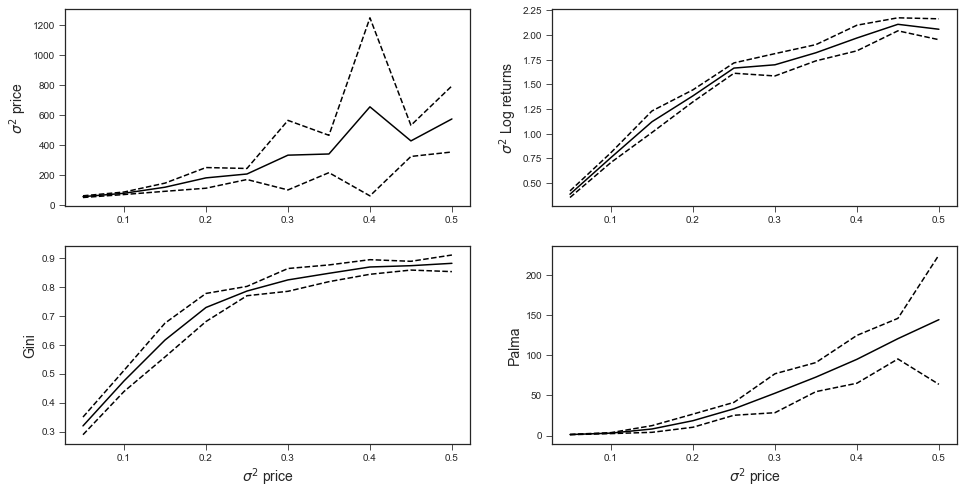

In [161]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=[16,8])

ax1.plot(stdev_fun, vol_averages, 'k')
ax1.plot(stdev_fun, vol_conf_interval_uppers, 'k--')
ax1.plot(stdev_fun, vol_conf_intervals_lowers, 'k--')

ax2.plot(stdev_fun, pr_averages, 'k')
ax2.plot(stdev_fun, pr_conf_interval_uppers, 'k--')
ax2.plot(stdev_fun, pr_conf_intervals_lowers, 'k--')

ax3.plot(stdev_fun, gini_averages, 'k')
ax3.plot(stdev_fun, gini_conf_interval_uppers, 'k--')
ax3.plot(stdev_fun, gini_conf_intervals_lowers, 'k--')

ax4.plot(stdev_fun, palma_averages, 'k')
ax4.plot(stdev_fun, palma_conf_interval_uppers, 'k--')
ax4.plot(stdev_fun, palma_conf_intervals_lowers, 'k--')


ax1.set_ylabel('$\sigma^2$ price', fontsize=14)
ax2.set_ylabel('$\sigma^2$ Log returns', fontsize=14)
ax3.set_ylabel('Gini', fontsize=14)
ax4.set_ylabel('Palma', fontsize=14)


for ax in [ax3, ax4]:
    ax.set_xlabel('$\sigma^2$ price', fontsize=14)

fig.savefig('vol_logrets_inequality.png', dpi=200, bbox_inches = 'tight', pad_inches = 0)

In [137]:
pd.DataFrame(portfolio_values)

,agent_0_seed_0,agent_1_seed_0,agent_2_seed_0,agent_3_seed_0,agent_4_seed_0,agent_5_seed_0,agent_6_seed_0,agent_7_seed_0,agent_8_seed_0,agent_9_seed_0,...,agent_90_seed_0,agent_91_seed_0,agent_92_seed_0,agent_93_seed_0,agent_94_seed_0,agent_95_seed_0,agent_96_seed_0,agent_97_seed_0,agent_98_seed_0,agent_99_seed_0
0,1878.776611,3610.326683,2307.990687,3980.555102,2888.991485,4014.904931,3017.459033,2060.448987,1816.777544,4730.882205,...,1914.337993,2025.514603,3698.501752,3467.256337,4671.415519,3670.394013,3044.587730,4444.848193,2625.748674,2716.368403
1,1878.776611,3610.326683,2307.990687,3980.555102,2888.991485,4007.492472,3017.459033,2060.448987,1816.777544,4730.882205,...,1914.337993,2025.514603,3698.501752,3467.256337,4671.415519,3670.394013,3044.587730,4509.875148,2625.748674,2716.368403
2,1881.864768,3613.414840,2314.167001,3986.731416,2898.255956,4010.580629,3017.459033,2060.448987,1819.865701,4740.146676,...,1917.426150,2031.690917,3701.589909,3473.432651,4680.679989,3673.482170,3044.587730,4525.315932,2631.924988,2722.544717
3,1886.509736,3618.059809,2323.456937,3996.021352,2912.190861,4015.225597,3017.459033,2060.448987,1824.510669,4754.081580,...,1911.288164,2040.980854,3706.234877,3482.722587,4694.614894,3678.127138,3044.587730,4548.540774,2641.214925,2731.834653
4,1892.345634,3623.895707,2335.128734,4007.693149,2929.698555,4021.061495,3017.459033,2060.448987,1830.346567,4771.589275,...,1911.288164,2052.652650,3712.070775,3494.394384,4712.122589,3683.963036,3044.587730,4577.720265,2652.886721,2743.506450
5,1893.525833,3634.049693,2337.489132,4010.053547,2933.239154,4022.241694,3017.459033,2060.448987,1831.526766,4775.129873,...,1911.288164,2055.013049,3680.247237,3496.754783,4715.663187,3685.143236,3044.587730,4583.621262,2655.247120,2745.866848
6,1892.435309,3717.830996,2378.834521,4051.398936,2995.257237,4042.914389,3017.459033,2060.448987,1852.199461,4837.147957,...,1911.288164,2096.358438,3680.247237,3555.699223,4777.681270,3705.815930,3044.587730,4686.984734,2696.592509,2787.212237
7,1892.435309,3697.974136,2368.906092,4041.470507,2980.364592,4037.950174,3017.459033,2060.448987,1847.235246,4822.255312,...,1921.857532,2086.430008,3680.247237,3540.806579,4762.788626,3700.851715,3044.587730,4662.163659,2686.664079,2777.283808
8,1892.435309,3736.168251,2388.003149,4060.567564,3009.010178,4047.498703,3017.459033,2085.886437,1875.743200,4850.900898,...,1879.016913,2105.527065,3680.247237,3598.485690,4791.434212,3710.400244,3044.587730,4709.906303,2705.761136,2796.380865
9,1892.435309,3687.102702,2363.470374,4036.034789,2972.211017,4035.232315,3017.459033,2061.353662,1851.210425,4848.734559,...,1879.016913,2080.994291,3680.247237,3549.420142,4754.635050,3698.133857,3044.587730,4648.574366,2681.228362,2771.848090


In [122]:
pd.DataFrame({'agent_1_seed_1':[1, 2, 3], 'agent_2_seed_2':[4,5,6]})

,agent_1_seed_1,agent_2_seed_2
0,1,4
1,2,5
2,3,6


In [113]:
wealth_starts = []
wealth_ends = []
ginis_ot = []
palmas_ot = []
returns = []
absolute_returns = []
market_returns = []

returns_ot = []
wealth_ot = []
log_returns_ot = []
log_wealth_ot = []

# determine the start and end wealth
for seed, traders in enumerate(trdrs):
    money_start = np.array([x.var.money[0] for x in traders])
    stocks_start = np.array([x.var.stocks[0] for x in traders])
    wealth_start = money_start + (stocks_start * orbs[seed].tick_close_price[0])

    money_end = np.array([x.var.money[-1] for x in traders])
    stocks_end = np.array([x.var.stocks[-1] for x in traders])
    wealth_end = money_end + (stocks_end * orbs[seed].tick_close_price[-1])
    
    # returns
    returns.append((np.array(wealth_end) - np.array(wealth_start)) / np.array(wealth_start))
    absolute_returns.append(np.array(wealth_end) - np.array(wealth_start))
    market_returns.append([(orbs[seed].tick_close_price[-1] - orbs[seed].tick_close_price[0]) / orbs[seed].tick_close_price[0] for x in range(len(wealth_start))])

    wealth_gini_over_time = []
    palma_over_time = []
    
    wealth_over_time = []
    returns_over_time = []
    log_returns_over_time = []
    log_wealth_over_time = []
    for t in range(params["ticks"]):
        money = np.array([x.var.money[t] for x in traders])
        stocks = np.array([x.var.stocks[t] for x in traders])
        wealth = money + (stocks * orbs[seed].tick_close_price[t])

        share_top_10 = sum(np.sort(wealth)[int(len(wealth) * 0.9):]) / sum(wealth)
        share_bottom_40 = sum(np.sort(wealth)[:int(len(wealth) * 0.4)]) / sum(wealth)
        palma_over_time.append(share_top_10 / share_bottom_40)

        wealth_gini_over_time.append(gini(wealth))
        
        for a in range(len(traders)):
            wealth_over_time.append(wealth[a])
            log_wealth_over_time.append(np.log(wealth[a]))

            if t > 0:
                returns_over_time.append((wealth_over_time[t] - wealth_over_time[t-1]) / wealth_over_time[-1])
                log_returns_over_time.append(np.log(wealth_over_time[t] / wealth_over_time[t-1])) # log returns = log(return + 1)

    wealth_starts.append(list(wealth_start))
    wealth_ends.append(list(wealth_end))
    ginis_ot.append(wealth_gini_over_time)
    palmas_ot.append(palma_over_time)
    
    returns_ot.append(returns_over_time)
    wealth_ot.append(wealth_over_time)
    log_returns_ot.append(log_returns_over_time)
    log_wealth_ot.append(log_wealth_over_time)

### Do log returns correlate with log wealth?

I need a df of all returns next to log returns next to wealth of the previous period, next to log wealth 

In [114]:
len(returns_ot[0])

49900

In [115]:
returns_and_wealth = pd.DataFrame([wealth_ot[0], log_wealth_ot[0], returns_ot[0], log_returns_ot[0]]).transpose().loc[499:49499].dropna()

In [116]:
returns_and_wealth.columns = ['wealth_t', 'log_wealth_t', 'return_t+1', 'log_returns_t+1']

In [117]:
returns_and_wealth[['wealth_t', 'log_wealth_t']].corrwith(returns_and_wealth[['return_t+1', 'log_returns_t+1']], axis=0)

log_returns_t+1   NaN
log_wealth_t      NaN
return_t+1        NaN
wealth_t          NaN
dtype: float64

In [110]:
#returns_and_wealth[['wealth_t', 'return_t+1']]

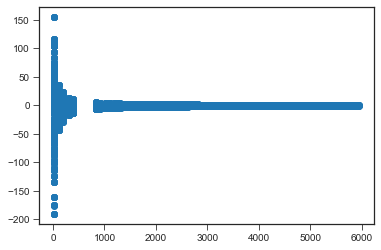

In [118]:
fig, ax = plt.subplots(nrows=1, ncols=1)

ax.scatter(returns_and_wealth['wealth_t'], returns_and_wealth['return_t+1'])

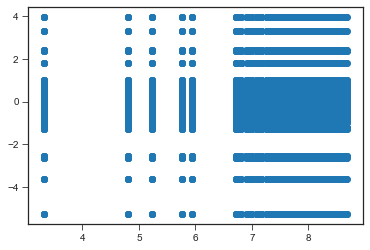

In [119]:
fig, ax = plt.subplots(nrows=1, ncols=1)

ax.scatter(returns_and_wealth['log_wealth_t'], returns_and_wealth['log_returns_t+1'])